In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
pd.options.display.max_rows = None
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# new OpenTNSim module
import powertrain

In [2]:
# power_applied = [86,147,208,270,331,392,453,515,576,637,698,760,821,882,943,1005,1066] # exclude stationary

MCR_smallsize = [700,750,800,850,900] 

MCR_oversize = [1225]

peaktime_percentage = [0.057]
peakpower_load_oversize = [0.77] #ARA_tanker ave

stationarytime_percentage = [0.174]
stationarypower_load_oversize = [0.025] #ARA_tanker ave

trip_total_time_hr = [27] # ARA tanker, AMS-RTD



In [3]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(
        MCR_smallsize, 
        trip_total_time_hr,
        peaktime_percentage,
        stationarytime_percentage,
        MCR_oversize,
        peakpower_load_oversize,
        stationarypower_load_oversize))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"MCR_smallsize":item[0],
           "trip_total_time_hr":item[1],"peaktime_percentage":item[2], "stationarytime_percentage": item[3], 
           "MCR_oversize":item[4], "peakpower_load_oversize": item[5], "stationarypower_load_oversize":item[6]
        }
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)

work_df

,MCR_smallsize,trip_total_time_hr,peaktime_percentage,stationarytime_percentage,MCR_oversize,peakpower_load_oversize,stationarypower_load_oversize
0,700,27,0.057,0.174,1225,0.77,0.025
1,750,27,0.057,0.174,1225,0.77,0.025
2,800,27,0.057,0.174,1225,0.77,0.025
3,850,27,0.057,0.174,1225,0.77,0.025
4,900,27,0.057,0.174,1225,0.77,0.025


In [4]:
feasibilities = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):


    (
        battery_capacity_for_trip_kwh, 
        battery_capacity_for_peakpower_kwh,                
        load_factor_tw_ave_ARA_smallsize,
    ) = powertrain.calculate_battery_capacity_forARA1smallICE(
        
        peakpower_load_oversize = row['peakpower_load_oversize'],
        stationarypower_load_oversize = row['stationarypower_load_oversize'],
        MCR_oversize = row['MCR_oversize'],                                                                                
        peaktime_percentage = row['peaktime_percentage'], 
        stationarytime_percentage = row['stationarytime_percentage'], 
        trip_total_time_hr = row['trip_total_time_hr'],                                                                                    
        MCR_smallsize_1 = row['MCR_smallsize'],      
        )    

    
    feasibility ={}
    feasibility.update(row)
    feasibility['battery_capacity_for_trip (kwh)'] = battery_capacity_for_trip_kwh #
    feasibility['battery_capacity_for_peakpower (kwh)'] = battery_capacity_for_peakpower_kwh
    feasibility['load_factor_tw_ave_ARA_smallsize'] = load_factor_tw_ave_ARA_smallsize

    
    feasibilities.append(feasibility)

In [5]:
feasibilities = pd.DataFrame(feasibilities)
first_selected = ['load_factor_tw_ave_ARA_smallsize','MCR_smallsize','battery_capacity_for_trip (kwh)','battery_capacity_for_peakpower (kwh)']
feasibilities = feasibilities[first_selected]
feasibilities = feasibilities[feasibilities['battery_capacity_for_trip (kwh)'] > 0 ] 
feasibilities = feasibilities[feasibilities['battery_capacity_for_peakpower (kwh)'] > 0] 
feasibilities = feasibilities[feasibilities['load_factor_tw_ave_ARA_smallsize'] < 1.01] 

feasibilities 

,load_factor_tw_ave_ARA_smallsize,MCR_smallsize,battery_capacity_for_trip (kwh),battery_capacity_for_peakpower (kwh)
0,0.463514,700.0,849.791250,535.95675
1,0.435843,750.0,768.031875,470.54925
2,0.411631,800.0,686.272500,405.14175
3,0.390268,850.0,604.513125,339.73425
4,0.371278,900.0,522.753750,274.32675


### ARA tanker right engine sizing scenario of two smaller ICE engines and battery pack

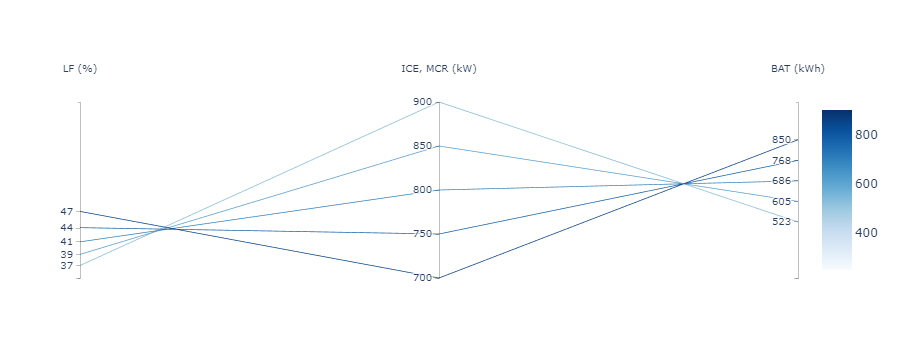

In [8]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = feasibilities ['battery_capacity_for_trip (kwh)'],
                   colorscale = 'blues',
                   showscale = True,
                   cmin = 250,
                   cmax = 900),
        dimensions = list([
            dict(range = [0.35,0.65],
                 # constraintrange = [2,3.5],
                 label = "LF (%)", values = feasibilities['load_factor_tw_ave_ARA_smallsize'],
                 tickvals = [0.65,0.463,0.435,0.412,0.39,0.371,0.35],
                 ticktext = ['','47', '44','41', '39', '37','']), 
            dict(range = [700,900],
                 # constraintrange = [2,3.5],
                 label = "ICE, MCR (kW)", values = feasibilities['MCR_smallsize'],
                 tickvals = [700,750,800,850,900],
                 ticktext = ['700','750', '800','850', '900']), 
            dict(range = [300,1000],
                 # constraintrange = [2,3.5],
                 label = "BAT (kWh)", values = feasibilities['battery_capacity_for_trip (kwh)'],
                 tickvals = [1000,850,768,686,605,523,300],
                 ticktext = ['','850', '768','686', '605', '523','']), 
        ]),
        unselected = dict(line = dict(color = 'gainsboro', opacity = 0.5))
    ) 
)


fig.show()

In [9]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/right_engine_size_selection_ARAtanker_1_smallICE_battery.html")